<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/projects/fMRI/CNN_HCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q nilearn nibabel pandas numpy matplotlib requests boto3 awscli seaborn
!pip install -q nibabel nilearn numpy scikit-learn matplotlib pandas scipy
!pip install -q hcp_utils brainspace actflow


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

# Necessary for visualization
from nilearn import plotting, datasets
from nilearn import image, plotting
from nilearn import surface
from nilearn.datasets import fetch_atlas_aal
import nilearn.plotting as plotting
from nilearn.surface import load_surf_mesh, vol_to_surf
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure

from scipy.stats import zscore

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

<ipython-input-2-71401b72cdb3>:21: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Generated by GPT, not yet verified

aal_network_labels = [
    "Visual", "Visual", "Visual", "Visual", "Somatomotor", "Somatomotor", "Somatomotor", "Somatomotor",
    "DorsalAttention", "DorsalAttention", "DorsalAttention", "DorsalAttention",
    "VentralAttention", "VentralAttention", "VentralAttention", "VentralAttention",
    "Limbic", "Limbic", "Limbic", "Limbic",
    "Frontoparietal", "Frontoparietal", "Frontoparietal", "Frontoparietal",
    "DefaultMode", "DefaultMode", "DefaultMode", "DefaultMode",
    "Subcortical", "Subcortical", "Subcortical", "Subcortical",
]

#Convert to numerical labels
network_dict = {net: idx for idx, net in enumerate(sorted(set(aal_network_labels)))}
network_labels_numeric = [network_dict[net] for net in aal_network_labels]

# Compute network order
netorder = np.argsort(network_labels_numeric)  # Sort ROIs by network

# Print network order for verification
print(f"Network order indices: {netorder}")

Network order indices: [27 24 25 26 11  8  9 10 21 20 22 23 16 17 18 19  6  5  4  7 30 28 29 31
 15 13 12 14  3  2  1  0]


In [5]:
# Paths
output_base_dir = "/content/drive/MyDrive/HCP_1200_processed"

# List of subjects to process
subject_list_path = "/content/drive/MyDrive/hcp1200_subjects.txt"
with open(subject_list_path, "r") as file:
    subject_ids = [line.strip() for line in file.readlines()]

subject_ids = subject_ids  # Use the first 30 subjects
N_SUBJECTS = len(subject_ids)

task_conditions = ["WM_LR_0bk_body", "WM_LR_2bk_body", "WM_LR_0bk_faces", "WM_LR_2bk_faces",
  "WM_LR_0bk_places", "WM_LR_2bk_places", "WM_LR_0bk_tools", "WM_LR_2bk_tools",
 "WM_RL_0bk_body", "WM_RL_2bk_body", "WM_RL_0bk_faces", "WM_RL_2bk_faces",
  "WM_RL_0bk_places", "WM_RL_2bk_places", "WM_RL_0bk_tools", "WM_RL_2bk_tools",
 "SOCIAL_LR_mental", "SOCIAL_LR_rnd", "SOCIAL_RL_mental", "SOCIAL_RL_rnd",
 ]

# Task and resting-state data
N_PARCELS = 84  # Number of AAL parcels
N_TASKS = 20     # Number of tasks
TIME_CHUNK = 1200  # Average over 1200 time points

# Initialize lists to store valid subject data
valid_subjects = []
restdata_list = []
activations_list = []
problematic_subjects = []  # Store subjects with incorrect task shape

# Load data for each subject
for subj_idx, subject_id in enumerate(subject_ids):
    subject_output_dir = os.path.join(output_base_dir, subject_id)

    # Load resting-state data
    rest_file = os.path.join(subject_output_dir, "rest.npy")
    if os.path.exists(rest_file):
        subject_restdata = np.load(rest_file)  # Shape: (84, timepoints)

        # Average over chunks of 1200 time points
        num_chunks = subject_restdata.shape[1] // TIME_CHUNK
        subject_restdata_avg = np.mean(
            subject_restdata[:, :num_chunks * TIME_CHUNK].reshape(N_PARCELS, num_chunks, TIME_CHUNK),
            axis=1
        )  # Shape: (84, 1200)

    else:
        print(f"WARNING: Missing resting-state data for Subject {subject_id}")
        continue  # Skip this subject

    # Load task activations
    task_file = os.path.join(subject_output_dir, "task.npy")
    if os.path.exists(task_file):
        subject_taskdata = np.load(task_file)  # Expected Shape: (84, 4)

        # Check for shape mismatch
        if subject_taskdata.shape[1] != N_TASKS:
            print(f"WARNING: Subject {subject_id} has task data shape {subject_taskdata.shape}, expected (84, {N_TASKS})")
            problematic_subjects.append(subject_id)
            continue  # Skip this subject

    else:
        print(f"WARNING: Missing task data for Subject {subject_id}")
        continue  # Skip this subject

    # Only add valid subjects
    valid_subjects.append(subject_id)
    restdata_list.append(subject_restdata_avg)
    activations_list.append(subject_taskdata)

# Convert lists to numpy arrays
restdata = np.stack(restdata_list, axis=2)  # Shape: (84, 1200, valid_subjects_count)
activations_bycond = np.stack(activations_list, axis=2)  # Shape: (84, 20, valid_subjects_count)

# Verify final shape
print("Final Restdata shape:", restdata.shape)  # Expected: (84, 1200, valid_subjects_count)
print("Final Activations_bycond shape:", activations_bycond.shape)  # Expected: (84, 20, valid_subjects_count)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Final Restdata shape: (84, 1200, 1096)
Final Activations_bycond shape: (84, 20, 1096)


In [6]:
def safe_corrcoef(X):
    """Compute correlation matrix with small regularization to avoid NaNs."""
    X = X - np.mean(X, axis=1, keepdims=True)  # Zero-center
    X_std = np.std(X, axis=1, keepdims=True)

    # Regularization: Avoid division by zero
    X_std[X_std < 1e-10] = 1e-10  # Small nonzero value to prevent NaNs
    X = X / X_std

    # Use np.nan_to_num to handle potential NaNs during correlation calculation
    corr_matrix = np.corrcoef(X)
    corr_matrix = np.nan_to_num(corr_matrix)
    return corr_matrix

In [7]:
# Replace NaNs with Small Nonzero Value
restdata = np.nan_to_num(restdata, nan=1e-10)  # Replace NaNs

# Compute Pearson Correlation FC (Keeps All ROIs)
restFC_corr = np.zeros((N_PARCELS, N_PARCELS, restdata.shape[2]))

for subj_idx in range(restdata.shape[2]):
    subject_restdata = restdata[:, :, subj_idx] #(84, 1200)

    if np.isnan(subject_restdata).sum() > 0:
        print(f"Warning: Subject {subj_idx} contains NaNs in `restdata`. Skipping FC calculation.")
        continue

    restFC_corr[:, :, subj_idx] = safe_corrcoef(subject_restdata)

nan_count = np.isnan(restFC_corr).sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values detected in `restFC_corr` after computation.")

print("Functional Connectivity Matrix Computed Successfully")


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Functional Connectivity Matrix Computed Successfully


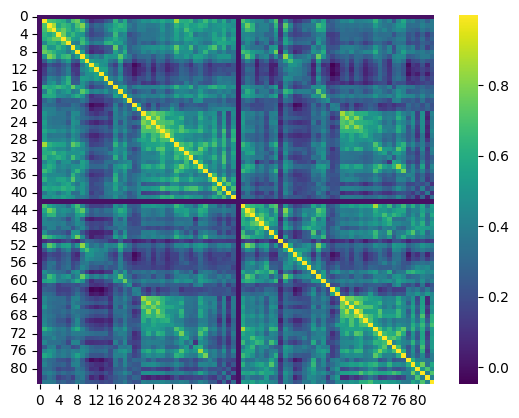

0.3456231694604705

In [8]:
sns.heatmap(restFC_corr.mean(axis=2), cmap='viridis')
plt.show()
restFC_corr.mean(axis=2).mean()

In [9]:
def compute_brainsurfcnn_task_contrast(activations_bycond, task_conditions):
    """
    Compute task contrasts following BrainSurfCNN’s exact methodology.

    activations_bycond: (ROI, num_tasks, subjects) -> Task activations for each condition
    task_conditions: List of task condition names

    Returns:
    task_contrast: (ROI, num_contrasts, subjects)
    """

    # Define condition pairs for contrasts (BrainSurfCNN structure)
    contrast_pairs = {
        "SOCIAL_LR": ["SOCIAL_LR_mental", "SOCIAL_LR_rnd"],
        "SOCIAL_RL": ["SOCIAL_RL_mental", "SOCIAL_RL_rnd"],
        "WM_LR_BODY": ["WM_LR_2bk_body", "WM_LR_0bk_faces"],
        "WM_LR_FACES": ["WM_LR_2bk_faces", "WM_LR_0bk_places"],
        "WM_LR_PLACE": ["WM_LR_2bk_places", "WM_LR_0bk_tools"],
        "WM_LR_TOOL": ["WM_LR_2bk_tools", "WM_LR_0bk_body"],
        "WM_RL_BODY": ["WM_RL_2bk_body", "WM_RL_0bk_faces"],
        "WM_RL_FACES": ["WM_RL_2bk_faces", "WM_RL_0bk_places"],
        "WM_RL_PLACE": ["WM_RL_2bk_places", "WM_RL_0bk_tools"],
        "WM_RL_TOOL": ["WM_RL_2bk_tools", "WM_RL_0bk_body"]
    }

    num_subjects = activations_bycond.shape[2]
    num_rois = activations_bycond.shape[0]
    task_contrast = np.zeros((num_rois, len(contrast_pairs), num_subjects))

    for i, (task, conditions) in enumerate(contrast_pairs.items()):
        try:
            # Get indices for paired conditions
            task_idx = task_conditions.index(conditions[0])  # Task condition
            baseline_idx = task_conditions.index(conditions[1])  # Control/Baseline condition

            # Compute contrast as (Task - Baseline)
            task_contrast[:, i, :] = (
                activations_bycond[:, task_idx, :] - activations_bycond[:, baseline_idx, :]
            )
        except ValueError:
            print(f"Skipping {task}: One or both conditions missing in task_conditions")

    return task_contrast

# Compute task contrast using BrainSurfCNN methodology
task_contrast = compute_brainsurfcnn_task_contrast(activations_bycond, task_conditions)

# Verify shape
print("BrainSurfCNN Task Contrast shape:", task_contrast.shape)  # Expected: (ROI, num_task_contrasts, subjects)


BrainSurfCNN Task Contrast shape: (84, 10, 1096)


In [10]:
output_dir = "/content/drive/MyDrive/cnn_processed_data"
os.makedirs(output_dir, exist_ok=True)

# Save adjusted task contrast
np.save(os.path.join(output_dir, "task_contrast_brainsurfcnn.npy"), task_contrast)
np.save(os.path.join(output_dir, "restFC_corr.npy"), restFC_corr)
print("Task Contrast and restFC saved successfully!")

Task Contrast and restFC saved successfully!


In [11]:
output_dir = "/content/drive/MyDrive/cnn_processed_data"
task_contrast_path = os.path.join(output_dir, "task_contrast_brainsurfcnn.npy")
restFC_corr_path = os.path.join(output_dir, "restFC_corr.npy")
contrast_pairs = {
        "SOCIAL_LR": ["SOCIAL_LR_mental", "SOCIAL_LR_rnd"],
        "SOCIAL_RL": ["SOCIAL_RL_mental", "SOCIAL_RL_rnd"],
        "WM_LR_BODY": ["WM_LR_2bk_body", "WM_LR_0bk_faces"],
        "WM_LR_FACES": ["WM_LR_2bk_faces", "WM_LR_0bk_places"],
        "WM_LR_PLACE": ["WM_LR_2bk_places", "WM_LR_0bk_tools"],
        "WM_LR_TOOL": ["WM_LR_2bk_tools", "WM_LR_0bk_body"],
        "WM_RL_BODY": ["WM_RL_2bk_body", "WM_RL_0bk_faces"],
        "WM_RL_FACES": ["WM_RL_2bk_faces", "WM_RL_0bk_places"],
        "WM_RL_PLACE": ["WM_RL_2bk_places", "WM_RL_0bk_tools"],
        "WM_RL_TOOL": ["WM_RL_2bk_tools", "WM_RL_0bk_body"]
    }


# Load data
task_contrast = np.load(task_contrast_path)
restFC_corr = np.load(restFC_corr_path)

# Display shape information
print("Loaded Task Contrast Shape:", task_contrast.shape)  # Expected: (ROI, num_task_contrasts, subjects)
print("Loaded Functional Connectivity Shape:", restFC_corr.shape)  # Expected: (ROI, ROI, subjects)

# Transpose data for PyTorch compatibility
task_contrast = task_contrast.transpose(2, 0, 1)  # (subjects, 84, num_task_contrasts)
restFC_corr = restFC_corr.transpose(2, 0, 1)  # Transpose to (subjects, ROI, ROI)
restFC_corr = restFC_corr[:, np.newaxis, ...] # Add a new dimension for channels


Loaded Task Contrast Shape: (84, 10, 1096)
Loaded Functional Connectivity Shape: (84, 84, 1096)


In [12]:
# Define split ratio
train_ratio = 0.8  # 80% training, 20% testing

# Get number of subjects
num_subjects = restFC_corr.shape[0]

# Split indices into train and test sets
train_indices, test_indices = train_test_split(np.arange(num_subjects), test_size=1-train_ratio, random_state=42)

# Create train and test datasets
train_fc = restFC_corr[train_indices]
train_task_contrast = task_contrast[train_indices]

test_fc = restFC_corr[test_indices]
test_task_contrast = task_contrast[test_indices]

print(f"Training subjects: {len(train_indices)}, Testing subjects: {len(test_indices)}")


Training subjects: 876, Testing subjects: 220


In [13]:
class BrainSurfCNN_Dataset(Dataset):
    def __init__(self, fc_data, task_contrast):
        """
        Args:
            fc_data (numpy array): Functional connectivity matrices (subjects, 1, 84, 84)
            task_contrast (numpy array): Task contrasts (subjects, 84, num_task_contrasts)
        """
        self.fc_data = torch.tensor(fc_data, dtype=torch.float32)
        self.task_contrast = torch.tensor(task_contrast, dtype=torch.float32)

    def __len__(self):
        return self.fc_data.shape[0]  # Number of subjects

    def __getitem__(self, idx):
        return self.fc_data[idx], self.task_contrast[idx]

# Create dataset
train_dataset = BrainSurfCNN_Dataset(train_fc, train_task_contrast)
test_dataset = BrainSurfCNN_Dataset(test_fc, test_task_contrast)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("Train & Test sets prepared!")

Train & Test sets prepared!


## Define BrainSurfCNN Model

In [14]:
class BrainSurfCNN(nn.Module):
    def __init__(self, roi_size=84, num_contrasts=10):
        super(BrainSurfCNN, self).__init__()

        # Encoding layers (Feature Extraction)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * roi_size * roi_size, 1024)
        self.fc2 = nn.Linear(1024, roi_size * num_contrasts)  # Output (ROI × Task Contrasts)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.dropout(x)
        x = x.view(x.shape[0], -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(x.shape[0], 84, 10)  # (Batch, ROI, num_task_contrasts)

# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainSurfCNN().to(device)

print("BrainSurfCNN model initialized and moved to GPU!")


BrainSurfCNN model initialized and moved to GPU!


In [15]:
class BrainSurfCNN(nn.Module):
    def __init__(self, roi_size=84, num_contrasts=10):
        super(BrainSurfCNN, self).__init__()

        ## ============================
        ## Downstream Path (Encoder)
        ## ============================
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        ## ============================
        ## Bottleneck Layer
        ## ============================
        self.conv_bottleneck = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_bottleneck = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)

        ## ============================
        ## Upstream Path (Decoder)
        ## ============================
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(64)

        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(32)

        ## ============================
        ## Fully Connected Layers
        ## ============================
        self.fc1 = nn.Linear(32 * roi_size * roi_size, 2048)  # Expanded FC for better learning
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(2048, roi_size * num_contrasts)  # Output: (ROI, Task Contrasts)

    def forward(self, x):
        ## Downstream Path (Encoder)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2)))
        x4 = F.relu(self.bn4(self.conv4(x3)))

        ## Bottleneck Layer
        x_bottleneck = F.relu(self.bn_bottleneck(self.conv_bottleneck(x4)))
        x_bottleneck = self.dropout(x_bottleneck)

        ## Upstream Path (Decoder)
        x = F.relu(self.bn5(self.deconv1(x_bottleneck)) + x4)  # Skip connection
        x = F.relu(self.bn6(self.deconv2(x)) + x3)  # Skip connection
        x = F.relu(self.bn7(self.deconv3(x)) + x2)  # Skip connection
        x = F.relu(self.bn8(self.deconv4(x)) + x1)  # Skip connection

        ## Fully Connected Output
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x.view(x.shape[0], 84, 10)  # Output shape: (Batch, ROI, Task Contrasts)

# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainSurfCNN().to(device)
print("BrainSurfCNN Model Initialized and moved to GPU!")


BrainSurfCNN Model Initialized and moved to GPU!


In [16]:
device

device(type='cuda')

In [17]:
import torch.optim as optim

# Set optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()  # Regression loss

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Use Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for fc_matrix, task_contrast in train_loader:
        fc_matrix, task_contrast = fc_matrix.to(device), task_contrast.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(fc_matrix)
            loss = criterion(outputs, task_contrast)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
    scheduler.step()

print("BrainSurfCNN training completed!")


<ipython-input-17-f1a0344ec978>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-17-f1a0344ec978>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Loss: 0.0543
Epoch [2/20], Loss: 0.0357
Epoch [3/20], Loss: 0.0362
Epoch [4/20], Loss: 0.0359
Epoch [5/20], Loss: 0.0355
Epoch [6/20], Loss: 0.0354
Epoch [7/20], Loss: 0.0354
Epoch [8/20], Loss: 0.0354
Epoch [9/20], Loss: 0.0354
Epoch [10/20], Loss: 0.0354
Epoch [11/20], Loss: 0.0354
Epoch [12/20], Loss: 0.0354
Epoch [13/20], Loss: 0.0354
Epoch [14/20], Loss: 0.0354
Epoch [15/20], Loss: 0.0353
Epoch [16/20], Loss: 0.0353
Epoch [17/20], Loss: 0.0353
Epoch [18/20], Loss: 0.0353
Epoch [19/20], Loss: 0.0353
Epoch [20/20], Loss: 0.0353
BrainSurfCNN training completed!


In [18]:
torch.save(model.state_dict(), "/content/drive/MyDrive/BrainSurfCNN.pth")

In [19]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Initialize dictionary to store correlations for each subject-task pair
subject_task_correlations = {}

model.eval()
with torch.no_grad():
    for subject_idx, (fc_matrix, task_contrast) in enumerate(test_loader):
        fc_matrix, task_contrast = fc_matrix.to(device), task_contrast.to(device)

        outputs = model(fc_matrix)  # Predicted values

        # Convert to numpy
        true_values = task_contrast.cpu().numpy()  # Shape: (batch_size, ROI, num_tasks)
        predicted_values = outputs.cpu().numpy()  # Same shape

        for batch_idx in range(true_values.shape[0]):  # Iterate over batch size
            subject_id = test_indices[subject_idx * test_loader.batch_size + batch_idx]  # Get original subject index

            task_correlations = []
            for task in range(true_values.shape[2]):  # Iterate over tasks
                true_vals = true_values[batch_idx, :, task]  # Shape: (ROI,)
                pred_vals = predicted_values[batch_idx, :, task]  # Shape: (ROI,)

                # Compute Pearson correlation if values are not constant
                if np.std(true_vals) > 0 and np.std(pred_vals) > 0:
                    r, _ = stats.pearsonr(true_vals, pred_vals)
                    task_correlations.append(r)
                else:
                    task_correlations.append(np.nan)  # Store NaN for constant values

            subject_task_correlations[subject_id] = task_correlations

# Convert to numpy array for further analysis
subject_task_correlations_array = np.array(list(subject_task_correlations.values()))

# Compute mean correlation per subject and across all subjects
mean_correlation_per_subject = np.nanmean(subject_task_correlations_array, axis=1)
overall_mean_correlation = np.nanmean(subject_task_correlations_array)

print(f"Overall Mean Correlation Across All Subjects and Tasks: {overall_mean_correlation:.4f}")

Overall Mean Correlation Across All Subjects and Tasks: 0.4399


<ipython-input-19-47e4edd3b977>:39: RuntimeWarning: Mean of empty slice
  mean_correlation_per_subject = np.nanmean(subject_task_correlations_array, axis=1)


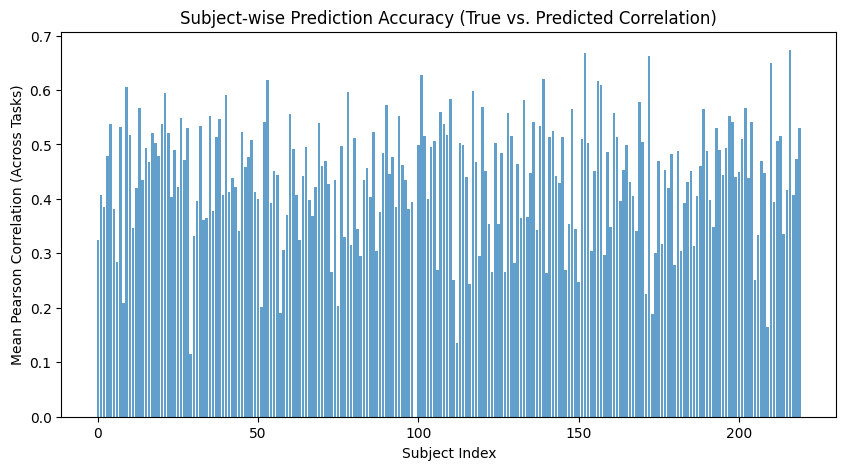

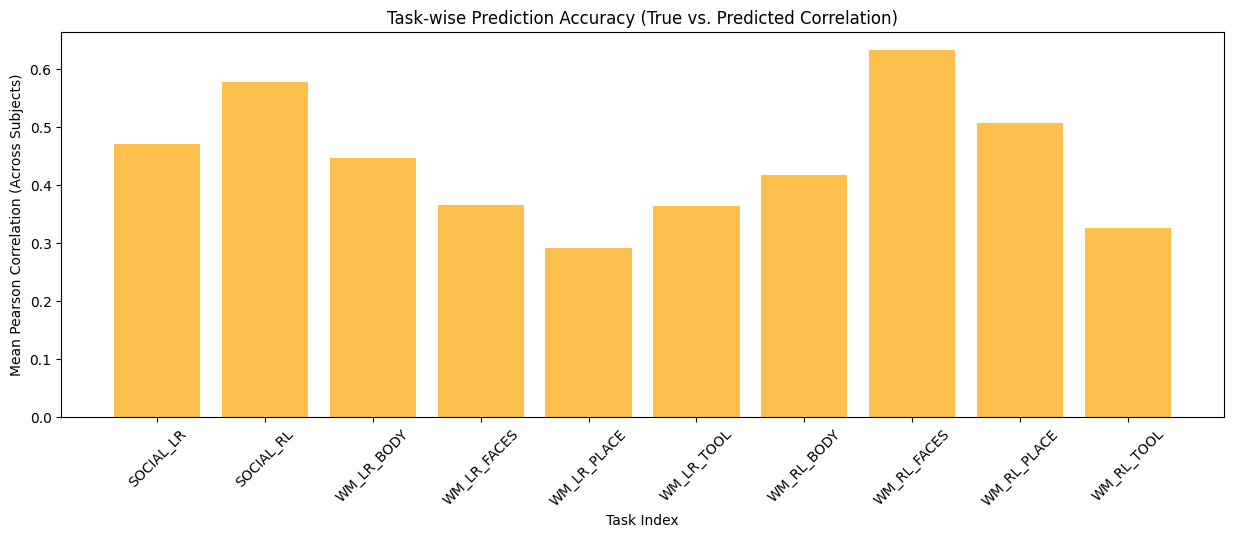

In [20]:
# Plot subject-wise correlation
plt.figure(figsize=(10, 5))
plt.bar(range(len(mean_correlation_per_subject)), mean_correlation_per_subject, alpha=0.7)
plt.xlabel("Subject Index")
plt.ylabel("Mean Pearson Correlation (Across Tasks)")
plt.title("Subject-wise Prediction Accuracy (True vs. Predicted Correlation)")
plt.show()

# Plot task-wise correlation (Mean correlation per task across all subjects)
mean_correlation_per_task = np.nanmean(subject_task_correlations_array, axis=0)

plt.figure(figsize=(15, 5))
plt.bar(contrast_pairs.keys() , mean_correlation_per_task, alpha=0.7, color='orange')
plt.xlabel("Task Index")
plt.ylabel("Mean Pearson Correlation (Across Subjects)")
plt.title("Task-wise Prediction Accuracy (True vs. Predicted Correlation)")
plt.xticks(rotation=45)
plt.show()


# Abide Data Preparation

In [21]:
# Download the phenotypic data
summary_url = "https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"
phenotypic_file = "phenotypic_data.csv"

# Download the CSV file
os.system(f"wget -O {phenotypic_file} {summary_url}")

# Load phenotypic data
phenotypic_data = pd.read_csv(phenotypic_file)

# Define the base URL and parameters
base_url = "https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Outputs"
pipeline = "cpac"
strategy = "filt_global"
derivative = "rois_aal"
file_ext = "1D"

# Separate ASD and TD subjects
asd_subjects = phenotypic_data[phenotypic_data["DX_GROUP"] == 1]["FILE_ID"].dropna()
td_subjects = phenotypic_data[phenotypic_data["DX_GROUP"] == 2]["FILE_ID"].dropna()

# Define download folders
asd_download_path = "abide_asd"
td_download_path = "abide_td"

os.makedirs(asd_download_path, exist_ok=True)
os.makedirs(td_download_path, exist_ok=True)

# Function to download files
def download_files(file_ids, download_path, label):
    for file_id in file_ids:
        file_name = f"{file_id}_{derivative}.{file_ext}"
        file_url = f"{base_url}/{pipeline}/{strategy}/{derivative}/{file_name}"
        file_path = os.path.join(download_path, file_name)

        if not os.path.exists(file_path):
            print(f"Downloading {label}: {file_name}")
            os.system(f"wget -q -P {download_path} {file_url}")
        else:
            print(f"Skipping {label}: {file_name} (already exists)")

# Download ASD data
download_files(asd_subjects, asd_download_path, "ASD")

# Download TD data
download_files(td_subjects, td_download_path, "TD")

print("Download complete.")


Skipping ASD: Pitt_0050003_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050004_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050005_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050006_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050007_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050008_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050009_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050010_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050011_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050012_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050013_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050014_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050015_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050016_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050017_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050019_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050020_rois_aal.1D (already exists)
Skipping ASD: Pitt_0050022_rois_aal.1D (already 

In [22]:
def process_abide_data(folder_path):
    """
    Process all subjects in the given folder, extracting only ROI 1-84
    and computing functional connectivity (FC) using nilearn.
    Returns: 3D numpy array (84, 84, N), where N is the number of valid subjects.
    """
    file_list = glob.glob(os.path.join(folder_path, "*.1D"))
    fc_matrices = []

    for file_path in file_list:
        try:
            # Load .1D file (TimePoints × ROIs)
            data = np.loadtxt(file_path)

            # Ensure it's in the correct shape (TimePoints × ROIs) and has at least 84 ROIs
            if data.shape[1] < 84:
                print(f"Skipping {file_path}, insufficient ROIs ({data.shape[1]} < 84)")
                continue

            # Extract only ROI 1-84
            data = data[:, :84]  # Shape: (TimePoints, 84)

            # Transpose to (ROIs, TimePoints) for FC calculation
            data = data.T  # Shape: (84, TimePoints)

            # Compute FC using nilearn's Pearson correlation method
            fc_matrix = safe_corrcoef(data)

            # Check if the FC matrix has the expected shape (84, 84)
            if fc_matrix.shape == (84, 84):
                fc_matrices.append(fc_matrix)
            else:
                print(f"Skipping {file_path}, unexpected FC matrix shape: {fc_matrix.shape}")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Convert list to numpy array (84, 84, N)
    if fc_matrices:
        return np.stack(fc_matrices, axis=-1)
    else:
        return np.array([])  # Return empty array if no valid data

# Process ASD and TD groups separately
asd_folder = "abide_asd"
td_folder = "abide_td"

print("Processing ASD subjects...")
restFC_corr_asd = process_abide_data(asd_folder)
print(f"ASD Functional Connectivity Shape: {restFC_corr_asd.shape}")

print("Processing TD subjects...")
restFC_corr_td = process_abide_data(td_folder)
print(f"TD Functional Connectivity Shape: {restFC_corr_td.shape}")

Processing ASD subjects...


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ASD Functional Connectivity Shape: (84, 84, 505)
Processing TD subjects...
TD Functional Connectivity Shape: (84, 84, 530)


ASD-ASD Similarity Mean: 0.5414883758583555
TD-TD Similarity Mean: 0.5595703236722837
ASD-TD Similarity Mean: 0.5469415031527759


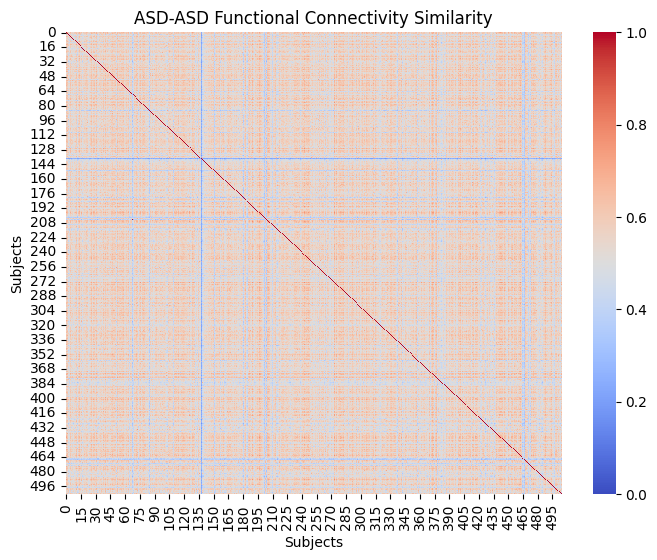

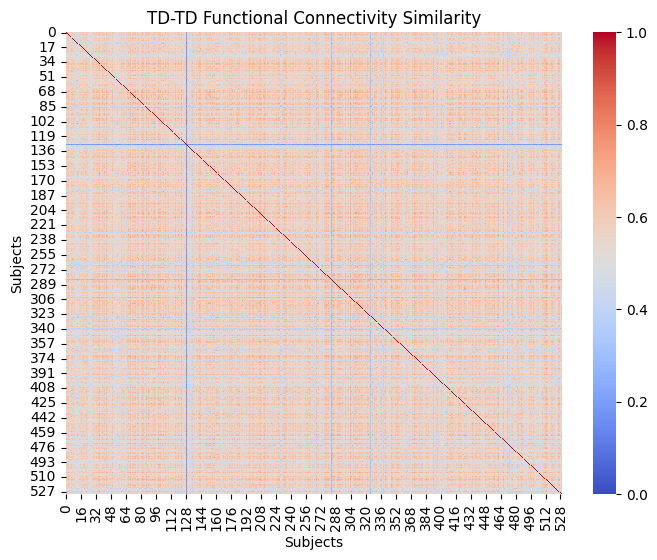

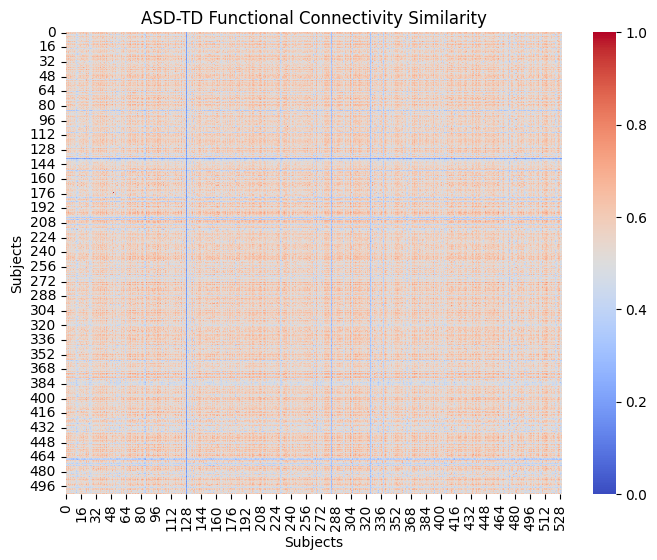

In [23]:
def compute_similarity(fc_matrices1, fc_matrices2):
    """
    Compute Pearson correlation between FC matrices.
    Returns a similarity matrix of shape (N1, N2), where:
    - N1 = number of subjects in fc_matrices1
    - N2 = number of subjects in fc_matrices2
    """
    N1 = fc_matrices1.shape[2]
    N2 = fc_matrices2.shape[2]

    # Flatten
    fc_vecs1 = fc_matrices1.reshape(84 * 84, N1)
    fc_vecs2 = fc_matrices2.reshape(84 * 84, N2)

    # Compute Pearson correlation between all pairs
    similarity_matrix = np.corrcoef(fc_vecs1.T, fc_vecs2.T)  # Shape: (N1+N2, N1+N2)
    return similarity_matrix[:N1, N1:]  # Extract only relevant part (N1, N2)

# Compute similarity within ASD, within TD, and between ASD & TD
asd_asd_sim = compute_similarity(restFC_corr_asd, restFC_corr_asd)  # (N_asd, N_asd)
td_td_sim = compute_similarity(restFC_corr_td, restFC_corr_td)      # (N_td, N_td)
asd_td_sim = compute_similarity(restFC_corr_asd, restFC_corr_td)    # (N_asd, N_td)

print(f"ASD-ASD Similarity Mean: {asd_asd_sim.mean()}")
print(f"TD-TD Similarity Mean: {td_td_sim.mean()}")
print(f"ASD-TD Similarity Mean: {asd_td_sim.mean()}")

# Visualization function
def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="coolwarm", vmin=0, vmax=1, center=0.5, annot=False)
    plt.title(title)
    plt.xlabel("Subjects")
    plt.ylabel("Subjects")
    plt.show()

# Plot intra-group and inter-group similarities
plot_heatmap(asd_asd_sim, "ASD-ASD Functional Connectivity Similarity")
plot_heatmap(td_td_sim, "TD-TD Functional Connectivity Similarity")
plot_heatmap(asd_td_sim, "ASD-TD Functional Connectivity Similarity")


# Test BrainSurfCNN Model on ABIDE dataset

<ipython-input-24-84d9cddf12a8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/BrainSurfCNN.pth"))


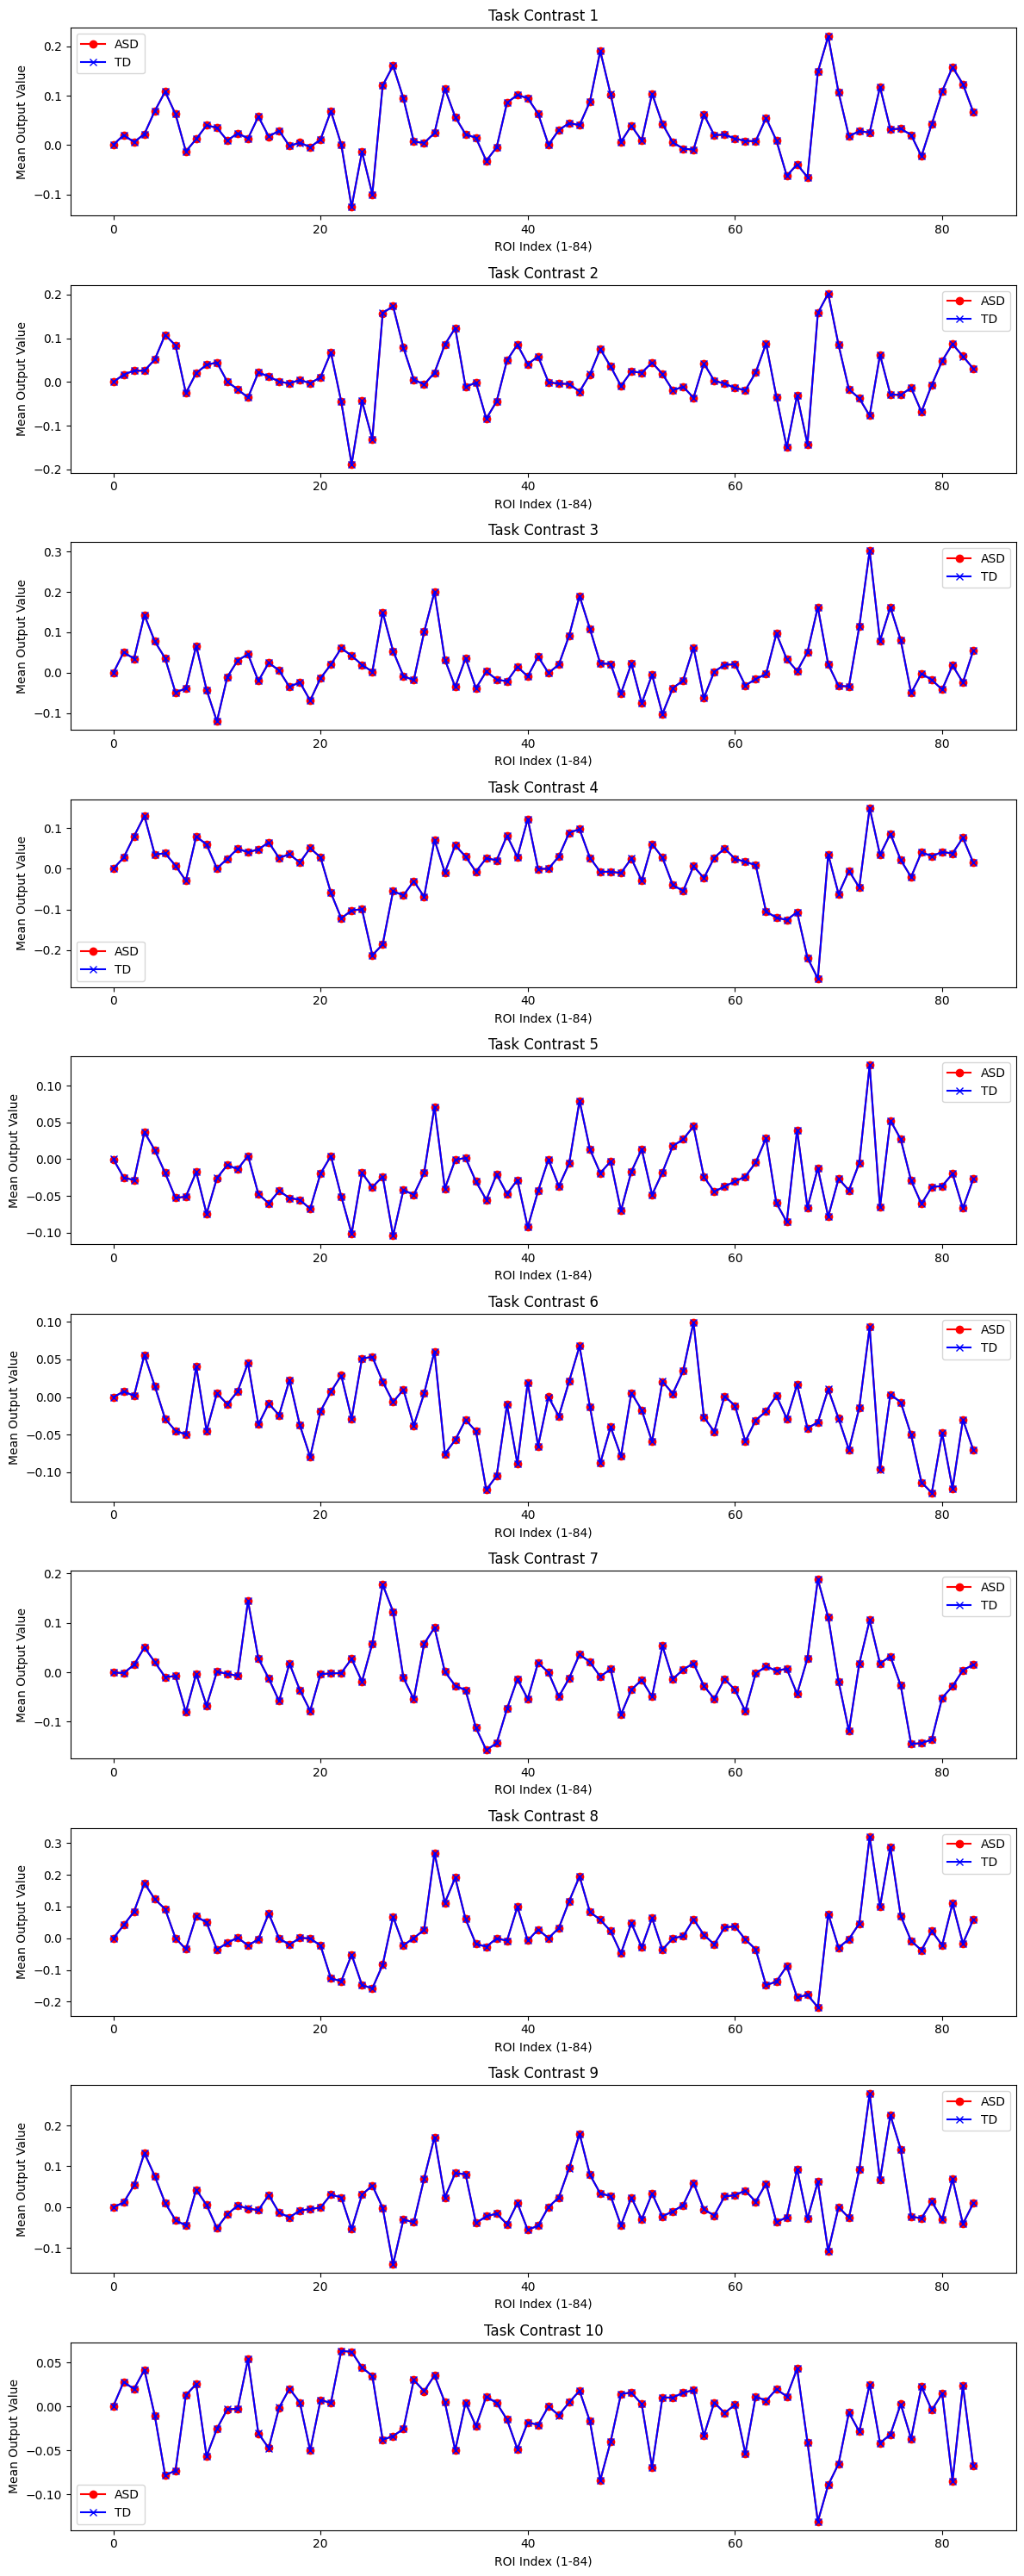

In [24]:
model = BrainSurfCNN()

model.load_state_dict(torch.load("/content/drive/MyDrive/BrainSurfCNN.pth"))

device = torch.device("cpu")
model.to(device)

# Transpose to (subjects, 84, 84)
restFC_corr_asd = np.moveaxis(restFC_corr_asd, -1, 0)  # Shape: (N_asd, 84, 84)
restFC_corr_td = np.moveaxis(restFC_corr_td, -1, 0)    # Shape: (N_td, 84, 84)

# Convert to PyTorch tensors and add a channel dimension (needed for CNN input)
restFC_corr_asd_tensor = torch.tensor(restFC_corr_asd[:, None, :, :], dtype=torch.float32).to(device)  # (N_asd, 1, 84, 84)
restFC_corr_td_tensor = torch.tensor(restFC_corr_td[:, None, :, :], dtype=torch.float32).to(device)  # (N_td, 1, 84, 84)

# Ensure model is in evaluation mode
model.eval()

# Function to get model predictions
def get_model_outputs(fc_tensor):
    with torch.no_grad():
        outputs = model(fc_tensor)  # Shape: (N_subjects, ROI=84, num_task_contrasts)
    return outputs.cpu().numpy()

# Get model outputs for ASD and TD groups
asd_outputs = get_model_outputs(restFC_corr_asd_tensor)
td_outputs = get_model_outputs(restFC_corr_td_tensor)

# Compute mean output across subjects
asd_mean_output = np.mean(asd_outputs, axis=0)
td_mean_output = np.mean(td_outputs, axis=0)

# Get the number of task contrasts
num_task_contrasts = asd_mean_output.shape[1]

# Plot each task contrast comparison
plt.figure(figsize=(12, num_task_contrasts * 3))
for task_idx in range(num_task_contrasts):
    plt.subplot(num_task_contrasts, 1, task_idx + 1)
    plt.plot(asd_mean_output[:, task_idx], label="ASD", linestyle='-', marker='o', color='r')
    plt.plot(td_mean_output[:, task_idx], label="TD", linestyle='-', marker='x', color='b')
    plt.xlabel("ROI Index (1-84)")
    plt.ylabel("Mean Output Value")
    plt.title(f"Task Contrast {task_idx + 1}")
    plt.legend()

plt.tight_layout()
plt.show()


[get_dataset_dir] Dataset found in /root/nilearn_data/aal_SPM12

<Figure size 1200x600 with 0 Axes>

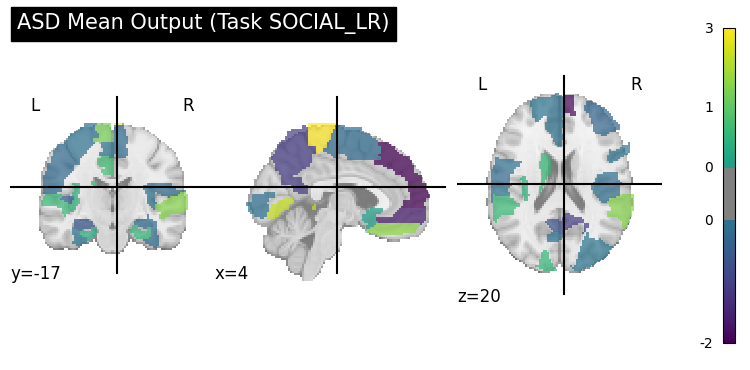

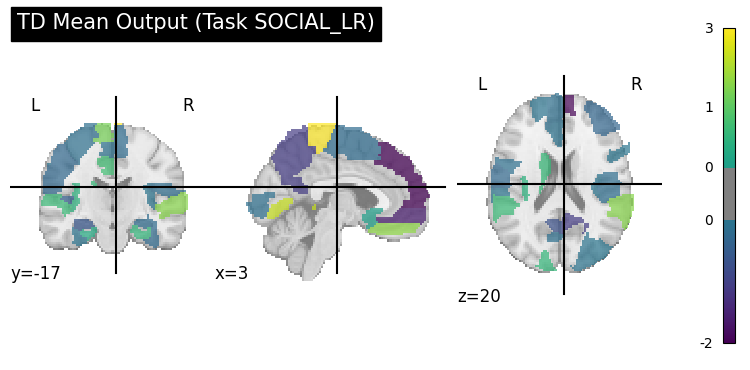

In [25]:
# Load AAL atlas
aal_atlas = datasets.fetch_atlas_aal()
aal_template_path = aal_atlas['maps']
aal_labels = aal_atlas['labels']

# Load atlas image
aal_template_img = nib.load(aal_template_path)
aal_data = aal_template_img.get_fdata()  # Get voxel-wise ROI indices

# Get unique ROI indices, excluding background (0)
unique_labels = np.unique(aal_data)
unique_labels = unique_labels[unique_labels > 0]
aal_label_mapping = {roi: i+1 for i, roi in enumerate(unique_labels)}
aal_data_mapped = np.vectorize(aal_label_mapping.get)(aal_data)

unique_labels = list(aal_label_mapping.values())[:84]

# Ensure ASD and TD arrays have enough values for the ROIs
if len(asd_mean_output[:, 0]) < len(unique_labels) or len(td_mean_output[:, 0]) < len(unique_labels):
    raise ValueError("Mismatch: ASD or TD mean output has fewer values than the number of valid ROIs!")

# Function to create projection images
def create_projection_img(mean_output, task_idx, title):
    """Maps mean_output[:, task_idx] onto AAL atlas."""
    projection_data = np.zeros_like(aal_data)

    for roi_index, roi_signal in zip(unique_labels, mean_output[:, task_idx]):
        projection_data[aal_data_mapped == roi_index] = roi_signal

    projection_img = nib.Nifti1Image(projection_data, affine=aal_template_img.affine)

    plotting.plot_roi(
        projection_img,
        title=title,
        display_mode='ortho',  # Orthogonal slices
        cmap='viridis',  # Color map
        colorbar=True,
    )

# Choose task index
task_idx = 0  # Change this to visualize other tasks

# Visualize ASD and TD mean output projections
plt.figure(figsize=(12, 6))
asd_mean_output = zscore(asd_mean_output,axis=0)
td_mean_output = zscore(td_mean_output, axis=0)
create_projection_img(asd_mean_output, task_idx, title=f'ASD Mean Output (Task {list(contrast_pairs.keys())[task_idx]})')
create_projection_img(td_mean_output, task_idx, title=f'TD Mean Output (Task {list(contrast_pairs.keys())[task_idx]})')

plotting.show()
plt.show()
